In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# load the data
df = pd.read_csv("bike_sales_100k.csv")

# Convert Date to date time
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day_of_Week'] = df['Date'].dt.dayofweek

# display basic information about the data
# print(df.info())
# print(df.head())


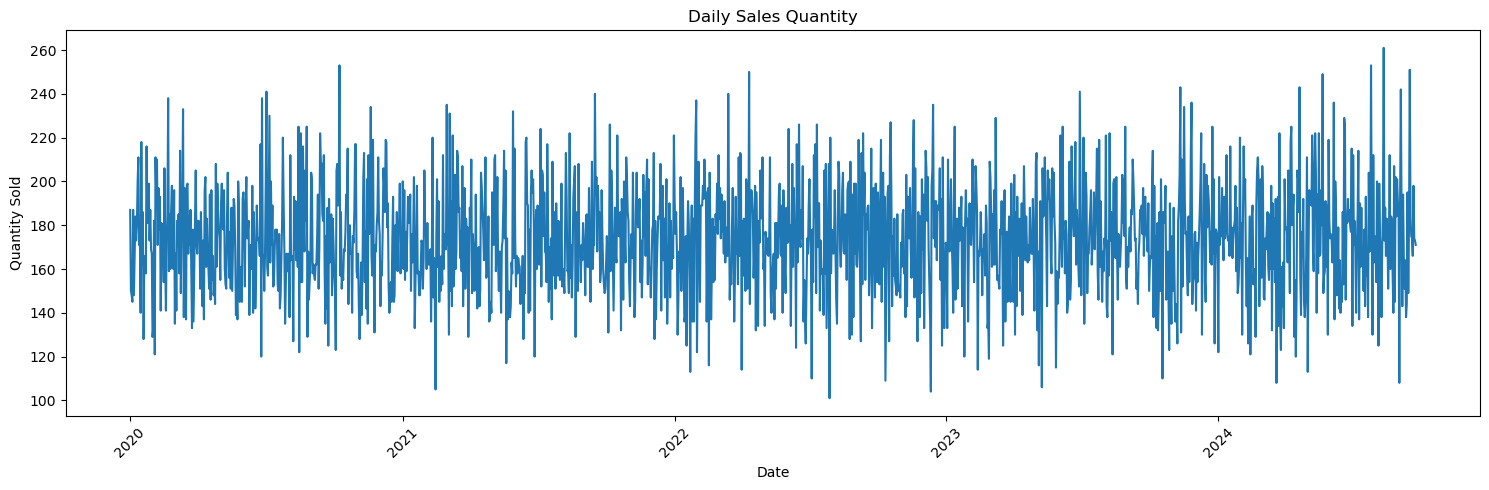

In [4]:
# analyze sales patterns over time

# daily sales
daily_sales = df.groupby('Date')['Quantity'].sum().reset_index()
plt.figure(figsize=(15, 5))
plt.plot(daily_sales['Date'], daily_sales['Quantity'])
plt.title('Daily Sales Quantity')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

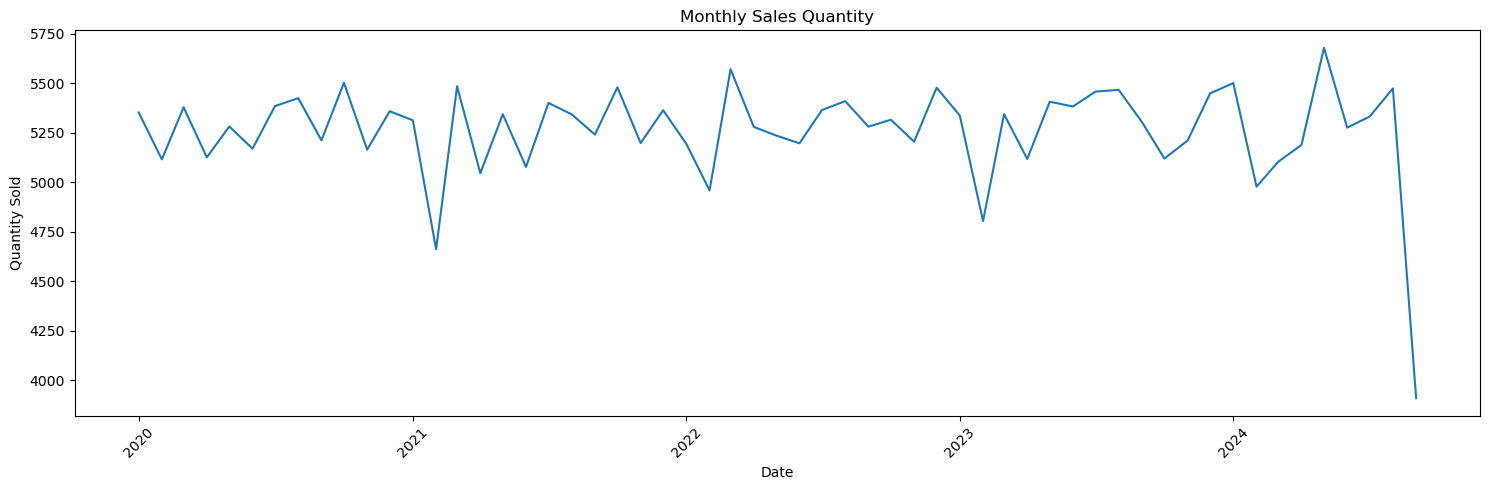

In [5]:
# monthly sales
monthly_sales = df.groupby(['Year', 'Month'])['Quantity'].sum().reset_index()
monthly_sales['Date'] = pd.to_datetime(monthly_sales[['Year', 'Month']].assign(DAY=1))

plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['Date'], monthly_sales['Quantity'])
plt.title('Monthly Sales Quantity')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### step 2: identify the supervised learning problem

For this dataset, I decided to choose to predict number of sales, since it can be treated as a regression problem, which is a supervised learning problem. So, I'm going to design a model to predict the quantities of bikes that will be sold in a single transaction based on features like bike model, price, customer demographic, store location, etc. The target variable in this problem would be quantity.


In [6]:
target_column = 'Quantity'
print(df[target_column].describe())

count    100000.000000
mean          2.997110
std           1.414235
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           5.000000
Name: Quantity, dtype: float64


In [21]:
# Separate numeric and categorical features
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
numeric_features = numeric_features.drop('Quantity')  # Exclude the target column
categorical_features = df.select_dtypes(include=['object']).columns

print("Numeric features:", numeric_features)
print("\nCategorical features:", categorical_features)

# Correlations for numeric features
numeric_correlations = df[numeric_features].corrwith(df[target_column])
print("\nCorrelations with Quantity (numeric features):")
print(numeric_correlations)

# For categorical features, we'll use a different approach
print("\nRelationship between categorical features and Quantity:")
for feature in categorical_features:
    if feature != 'Date':  # Exclude Date as we've already analyzed it
        print(f"\n{feature}:")
        print(df.groupby(feature)[target_column].mean().sort_values(ascending=False))


df.head()

Numeric features: Index(['Sale_ID', 'Customer_ID', 'Price', 'Salesperson_ID', 'Customer_Age'], dtype='object')

Categorical features: Index(['Bike_Model', 'Store_Location', 'Payment_Method', 'Customer_Gender'], dtype='object')

Correlations with Quantity (numeric features):
Sale_ID          -0.009547
Customer_ID       0.001730
Price            -0.001376
Salesperson_ID   -0.003357
Customer_Age     -0.000020
dtype: float64

Relationship between categorical features and Quantity:

Bike_Model:
Bike_Model
Hybrid Bike      3.009219
Cruiser          3.008652
BMX              2.996453
Mountain Bike    2.996173
Road Bike        2.995335
Folding Bike     2.991974
Electric Bike    2.981791
Name: Quantity, dtype: float64

Store_Location:
Store_Location
Houston         3.011308
Los Angeles     3.010628
New York        3.009852
Chicago         2.999507
San Antonio     2.986783
Phoenix         2.982343
Philadelphia    2.979623
Name: Quantity, dtype: float64

Payment_Method:
Payment_Method
Debit Card 

,Sale_ID,Date,Customer_ID,Bike_Model,Price,Quantity,Store_Location,Salesperson_ID,Payment_Method,Customer_Age,Customer_Gender,Year,Month,Day_of_Week
0,1,2022-07-11,9390,Cruiser,318.32,1,Philadelphia,589,Apple Pay,70,Female,2022,7,0
1,2,2024-05-03,3374,Hybrid Bike,3093.47,4,Chicago,390,Apple Pay,37,Male,2024,5,4
2,3,2022-09-01,2689,Folding Bike,4247.99,3,San Antonio,338,PayPal,59,Female,2022,9,3
3,4,2022-09-28,3797,Mountain Bike,1722.01,3,San Antonio,352,Apple Pay,19,Male,2022,9,2
4,5,2021-01-05,1633,BMX,3941.44,3,Philadelphia,580,PayPal,67,Female,2021,1,1


### Planing the machine learning approach
For this part, I am going to use RandomForestRegressor to predict the sales based on quantity. As the input to the model. To divide the data set into training and test sets, I am going to use 80% of data for training, and test the model on the remaining 20%.

It is also possible to use LinearRegression model to predit the sales.


['Price']
     Price
0   318.32
1  3093.47
2  4247.99
3  1722.01
4  3941.44
0    1
1    4
2    3
3    3
4    3
Name: Quantity, dtype: int64
count    100.000000
mean       2.970000
std        1.359256
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: Quantity, dtype: float64
[1 4 3 5 2]


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


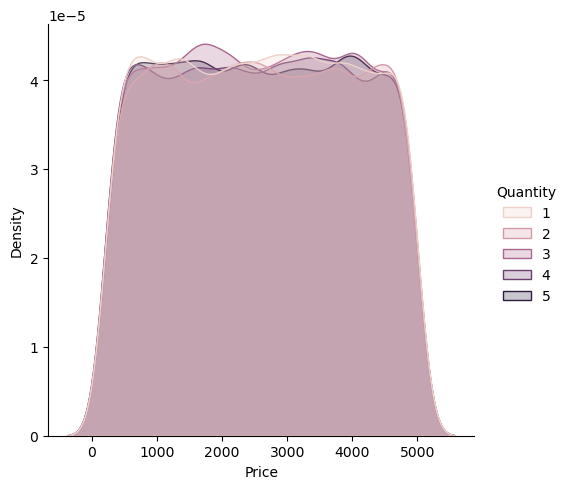

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
# ordinal_features = ['Bike_Model', 'Store_Location', 'Payment_Method', 'Customer_Gender', 'Year', 'Month', 'Day_of_Week']
selected_features = ['Price']#, 'Customer_Age']
# selected_features = ['Customer_Age']
# selected_features.extend(ordinal_features)
print(selected_features)
X = df[selected_features][:100]
y = df[target_column][:100]

print(X.head())
print(y.head())
print(y.describe())
print(y.unique())

# price distribution against a certain quantity. So for quantity=1 got a bell curve, and quantity=2 got another bell curve, and so on. And then look at their distribution attributesplot the data on a distribution plot
sns.displot(df, x='Price', hue='Quantity', kind='kde', fill=True)



n_estimators=50: MSE=2.517965902222222, MAE=1.2574133333333335, Score=-0.32470487155093175


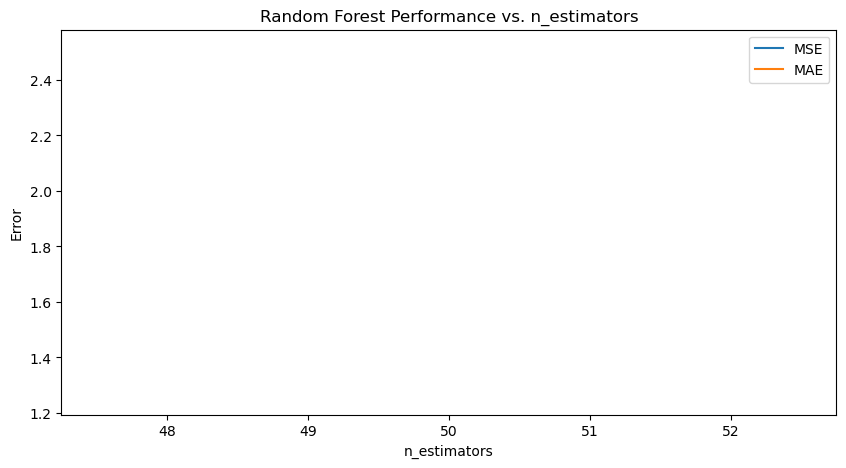

In [47]:
# ohe = OneHotEncoder(sparse=False)
# X_encoded = pd.DataFrame(ohe.fit_transform(X[ordinal_features]))

# X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
n_estimators = [50] #, 100, 200, 400]
mse_list = []
mae_list = []
score_list = []
for i in n_estimators:
    model = RandomForestRegressor(n_estimators=i, random_state=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    score = model.score(X_test, y_test)
    print(f"n_estimators={i}: MSE={mse}, MAE={mae}, Score={score}")
    mse_list.append(mse)
    mae_list.append(mae)
    score_list.append(score)


# importances  = model.feature_importances_
# for feature, importance in zip(X_encoded.columns, importances):
#     print(f"{feature}: {importance}")
plt.figure(figsize=(10, 5))
plt.plot(n_estimators, mse_list, label='MSE')
plt.plot(n_estimators, mae_list, label='MAE')
plt.title('Random Forest Performance vs. n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Error')
plt.legend()
plt.show()

Now I want to use  Categorical features to fit the model

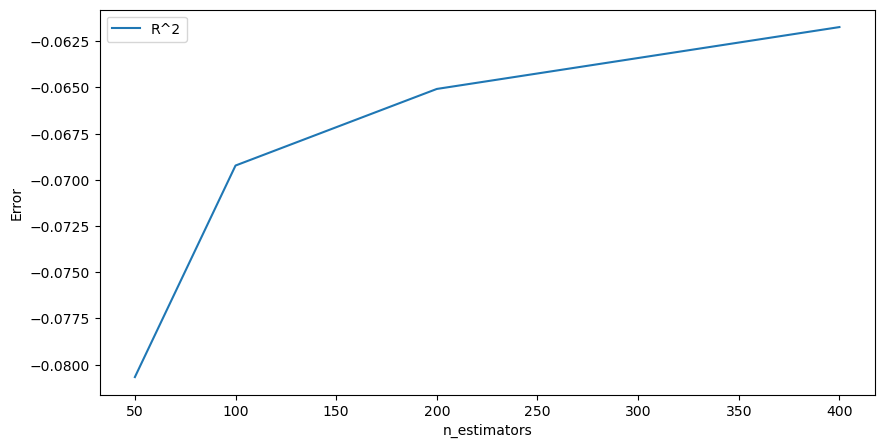

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(n_estimators, score_list, label='R^2')
plt.xlabel('n_estimators')
plt.ylabel('Error')
plt.legend()
plt.show()

Based on these analysis, categorical data improved model's performance, as both the MAE and MSE errors decreased.

In addition, the errors in the model trained with categorical data were more consistent. 

Another point is regarding the n_estimators. As we can see in both charts, the MAE and MSE decreased when n_estimators = 100, and then both of them start to increase again. This suggests that 100 is a good number of n_estimators, and going over that would cause diminishing returns.

Next, I'm going to use gradient boosting models. I'm also going to use a feature scaler to improve the model.

In [16]:

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

# fix this issue
X = df[]



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)


models = {
  "SVR": SVR(),
  "XGBoost": XGBRegressor(n_estimators = 100, random_state=5),
  "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=5),
  "Random Forest": RandomForestRegressor(n_estimators=100, random_state=5)
}
results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = model.score(X_test_scaled, y_test)
    results.append((name, mse, mae, r2))

print("Results:")
for name, mse, mae, r2 in results:
    print(f"{name}: MSE={mse}, MAE={mae}, R2={r2}")

ValueError: could not convert string to float: 'Folding Bike'

As we can see, the gradient boosting model has the lowest MSE and MAE, and the highest R2 score, indicating that it performs the best among the models we tested. We can use this model to make predictions on new data.

Initially, I thought XGBoost would perform better as it is an optimized version of gradient boosting, but in this case, I believe the dataset's characteristics align better with the standard gradient boosting implementation.

I feel that since gradient boosting builds trees sequentially, it allows it to focus on the harder-to-predict cases in each iteration.
Another thing that I think contributes to the gradient boosting performance is its flexibility. As it can capture non-leaner relationships in the data without requiring much feature engineering, I feel that's why it's performing better than the other models.

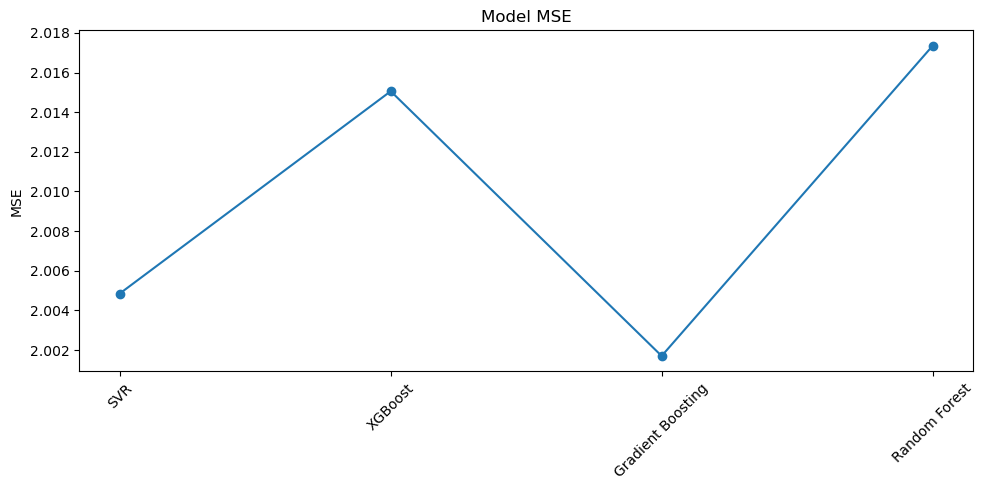

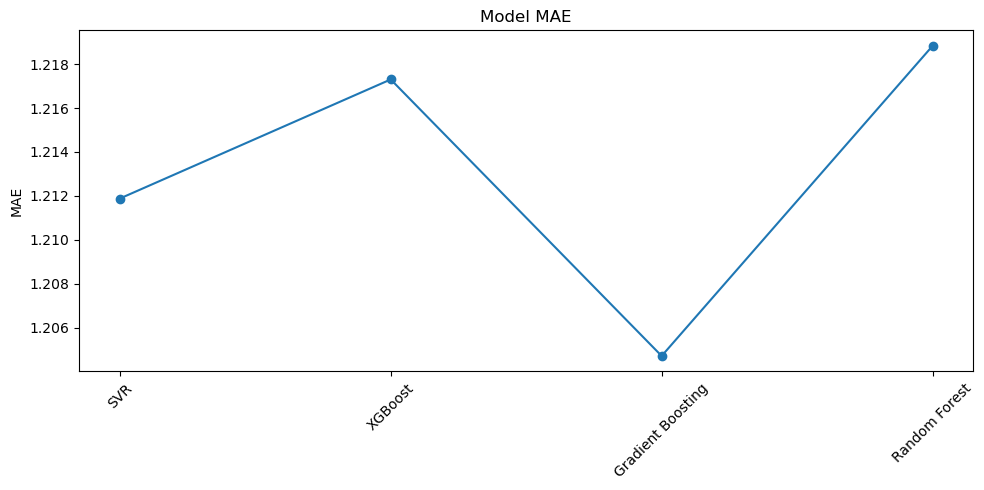

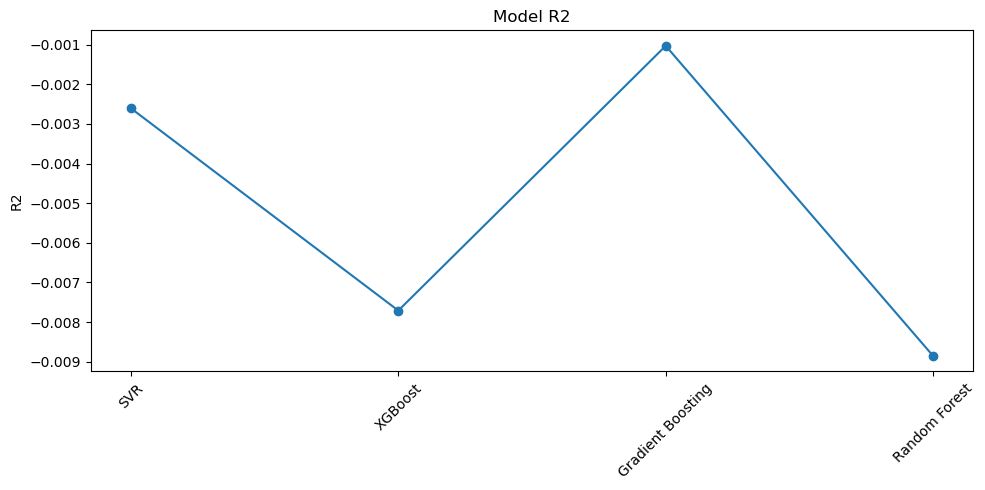

In [13]:
# Analyze each metric separately each in a separate line chart

plt.figure(figsize=(10, 5))
plt.plot(names, mse_values, label='MSE', marker='o')
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(names, mae_values, label='MAE', marker='o')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(names, r2_values, label='R2', marker='o')
plt.title('Model R2')
plt.ylabel('R2')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


